In [14]:
import numpy as np
from fractions import Fraction
from math import floor, gcd, log
 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFTGate
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
import os

import time

QiskitRuntimeService.save_account(
    token=os.getenv('IBMQ_API_KEY'),
    channel="ibm_quantum_platform",
    overwrite=True
)

In [4]:
def M2mod15():
    """
    M2 (mod 15)
    """
    b = 2
    U = QuantumCircuit(4)
 
    U.swap(2, 3)
    U.swap(1, 2)
    U.swap(0, 1)
 
    U = U.to_gate()
    U.name = f"M_{b}"
 
    return U

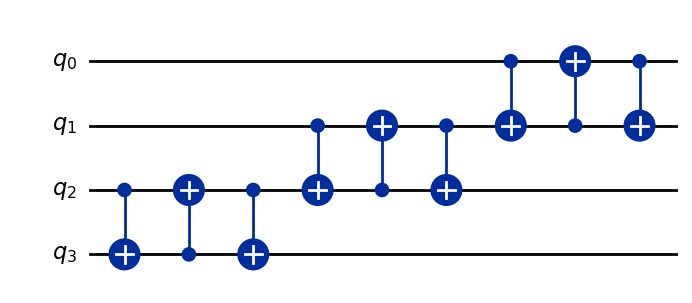

In [5]:
# Get the M2 operator
M2 = M2mod15()
 
# Add it to a circuit and plot
circ = QuantumCircuit(4)
circ.compose(M2, inplace=True)
circ.decompose(reps=2).draw(output="mpl", fold=-1)

In [6]:
def controlled_M2mod15():
    """
    Controlled M2 (mod 15)
    """
    b = 2
    U = QuantumCircuit(4)
 
    U.swap(2, 3)
    U.swap(1, 2)
    U.swap(0, 1)
 
    U = U.to_gate()
    U.name = f"M_{b}"
    c_U = U.control()
 
    return c_U

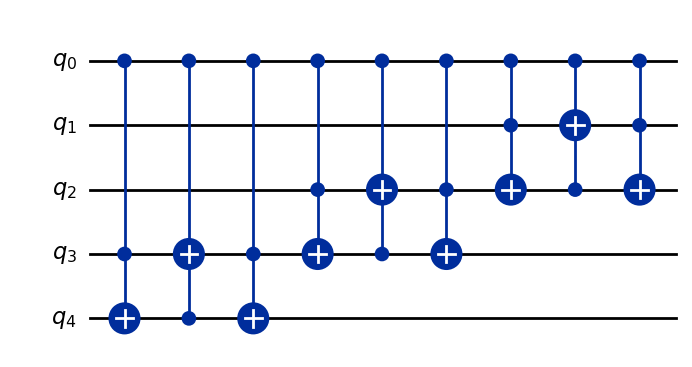

In [7]:
# Get the controlled-M2 operator
controlled_M2 = controlled_M2mod15()
 
# Add it to a circuit and plot
circ = QuantumCircuit(5)
circ.compose(controlled_M2, inplace=True)
circ.decompose(reps=1).draw(output="mpl", fold=-1)

In [8]:
def a2kmodN(a, k, N):
    """Compute a^{2^k} (mod N) by repeated squaring"""
    for _ in range(k):
        a = int(np.mod(a**2, N))
    return a

In [9]:
k_list = range(8)
b_list = [a2kmodN(2, k, 15) for k in k_list]
 
print(b_list)

[2, 4, 1, 1, 1, 1, 1, 1]


In [17]:
def M4mod15():
    """
    M4 (mod 15)
    """
    b = 4
    U = QuantumCircuit(4)
 
    U.swap(1, 3)
    U.swap(0, 2)
 
    U = U.to_gate()
    U.name = f"M_{b}"
 
    return U

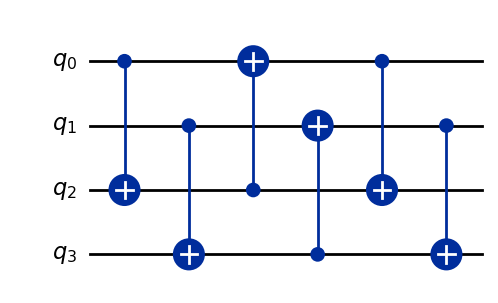

In [18]:
# Get the M4 operator
M4 = M4mod15()
 
# Add it to a circuit and plot
circ = QuantumCircuit(4)
circ.compose(M4, inplace=True)
circ.decompose(reps=2).draw(output="mpl", fold=-1)

In [19]:
def controlled_M4mod15():
    """
    Controlled M4 (mod 15)
    """
    b = 4
    U = QuantumCircuit(4)
 
    U.swap(1, 3)
    U.swap(0, 2)
 
    U = U.to_gate()
    U.name = f"M_{b}"
    c_U = U.control()
 
    return c_U

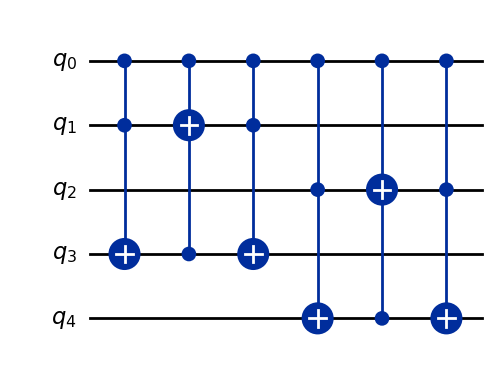

In [20]:
# Get the controlled-M4 operator
controlled_M4 = controlled_M4mod15()
 
# Add it to a circuit and plot
circ = QuantumCircuit(5)
circ.compose(controlled_M4, inplace=True)
circ.decompose(reps=1).draw(output="mpl", fold=-1)

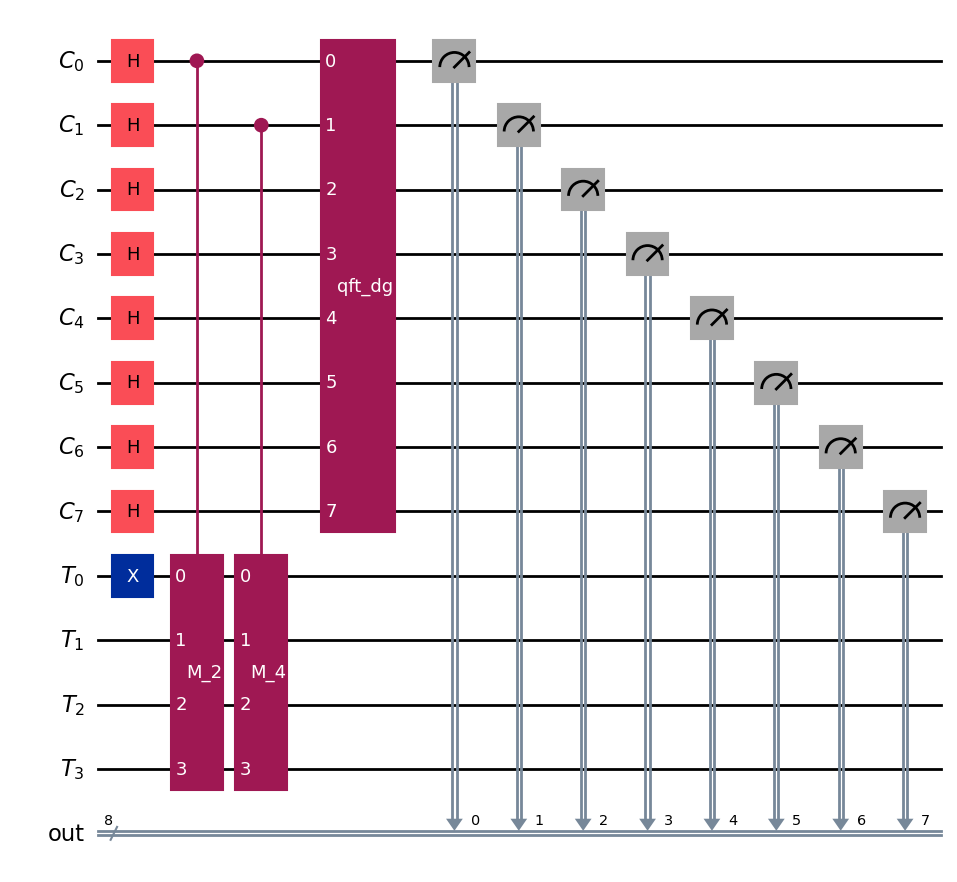

In [21]:
# Order finding problem for N = 15 with a = 2
N = 15
a = 2
 
# Number of qubits
num_target = floor(log(N - 1, 2)) + 1  # for modular exponentiation operators
num_control = 2 * num_target  # for enough precision of estimation
 
# List of M_b operators in order
k_list = range(num_control)
b_list = [a2kmodN(2, k, 15) for k in k_list]
 
# Initialize the circuit
control = QuantumRegister(num_control, name="C")
target = QuantumRegister(num_target, name="T")
output = ClassicalRegister(num_control, name="out")
circuit = QuantumCircuit(control, target, output)
 
# Initialize the target register to the state |1>
circuit.x(num_control)
 
# Add the Hadamard gates and controlled versions of the
# multiplication gates
for k, qubit in enumerate(control):
    circuit.h(k)
    b = b_list[k]
    if b == 2:
        circuit.compose(
            M2mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    elif b == 4:
        circuit.compose(
            M4mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    else:
        continue  # M1 is the identity operator
 
# Apply the inverse QFT to the control register
circuit.compose(QFTGate(num_control).inverse(), qubits=control, inplace=True)
 
# Measure the control register
circuit.measure(control, output)
 
circuit.draw("mpl", fold=-1)

In [22]:
service = QiskitRuntimeService()
 
backend = service.backend("ibm_marrakesh")

qiskit_runtime_service.__init__:WARNING:2026-01-28 10:32:27,653: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-01-28 10:32:27,653: Using instance: open-instance, plan: open


2q-depth: 205
2q-size: 277
Operator counts: OrderedDict({'sx': 548, 'rz': 406, 'cz': 277, 'x': 16, 'measure': 8})


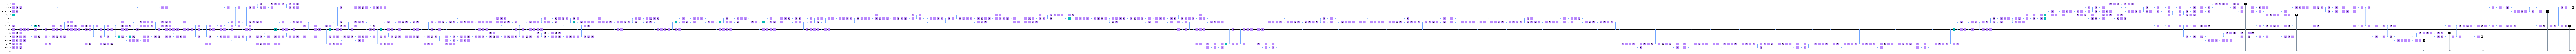

In [23]:
pm = generate_preset_pass_manager(optimization_level=2, backend=backend)
 
transpiled_circuit = pm.run(circuit)
 
print(f"2q-depth: {transpiled_circuit.depth(lambda x: x.operation.num_qubits==2)}")
print(f"2q-size: {transpiled_circuit.size(lambda x: x.operation.num_qubits==2)}")
print(f"Operator counts: {transpiled_circuit.count_ops()}")
transpiled_circuit.draw(output="mpl", fold=-1, style="clifford", idle_wires=False)

In [31]:
# Sampler primitive to obtain the probability distribution
sampler = Sampler(backend)
 
# Turn on dynamical decoupling with sequence XpXm
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"
# Enable gate twirling
sampler.options.twirling.enable_gates = True
start_time = time.perf_counter()

pub = transpiled_circuit
job = sampler.run([pub], shots=1024)

In [32]:
result = job.result()[0]
counts = result.data["out"].get_counts()

end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.4f} seconds")

Time taken: 469.2233 seconds


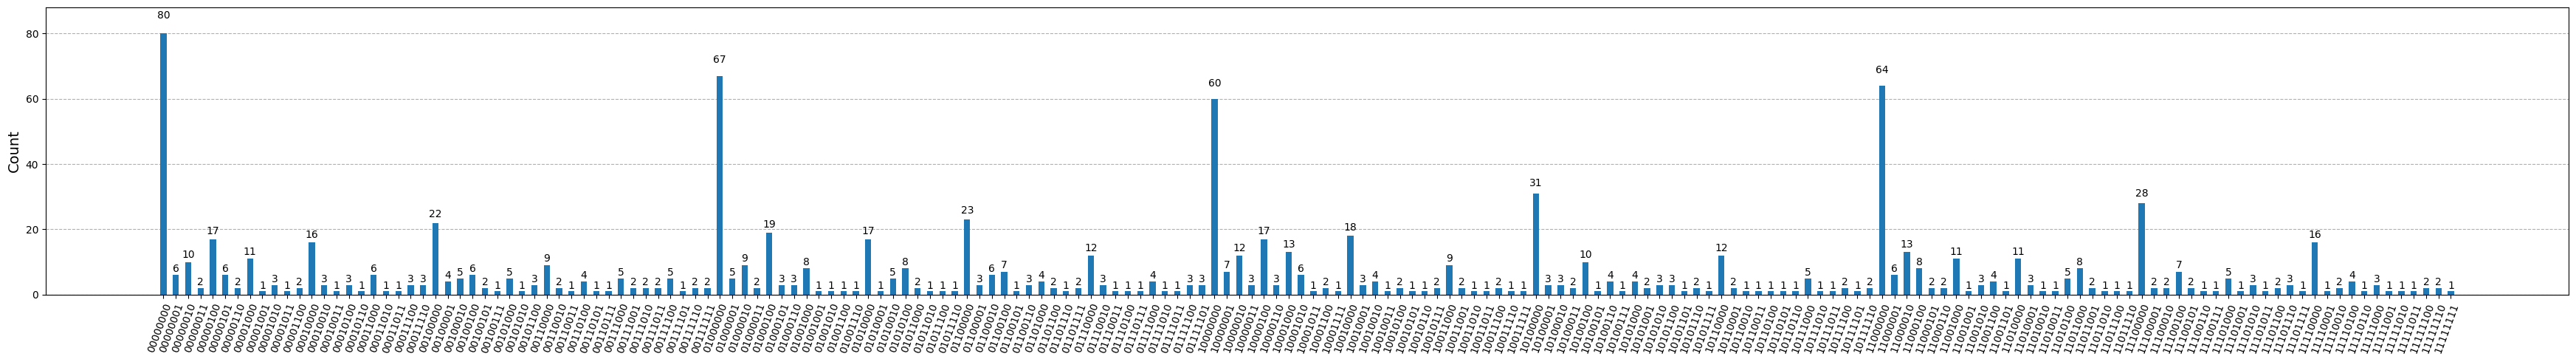

In [33]:
plot_histogram(counts, figsize=(35, 5))

In [27]:
# Dictionary of bitstrings and their counts to keep
counts_keep = {}
# Threshold to filter
threshold = np.max(list(counts.values())) / 2
 
for key, value in counts.items():
    if value > threshold:
        counts_keep[key] = value
 
print(counts_keep)

{'00000000': 84, '10000000': 83, '01000000': 78, '11000000': 68}


In [35]:
a = 2
N = 15
 
FACTOR_FOUND = False
num_attempt = 0
 
while not FACTOR_FOUND:
    print(f"\nATTEMPT {num_attempt}:")
    # Here, we get the bitstring by iterating over outcomes
    # of a previous hardware run with multiple shots.
    # Instead, we can also perform a single-shot measurement
    # here in the loop.
    bitstring = list(counts_keep.keys())[num_attempt]
    num_attempt += 1
    # Find the phase from measurement
    decimal = int(bitstring, 2)
    phase = decimal / (2**num_control)  # phase = k / r
    print(f"Phase: theta = {phase}")
 
    # Guess the order from phase
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator  # order = r
    print(f"Order of {a} modulo {N} estimated as: r = {r}")
 
    if phase != 0:
        # Guesses for factors are gcd(a^{r / 2} ± 1, 15)
        if r % 2 == 0:
            x = pow(a, r // 2, N) - 1
            d = gcd(x, N)
            if d > 1:
                FACTOR_FOUND = True
                print(f"*** Non-trivial factor found: {x} ***")


ATTEMPT 0:
Phase: theta = 0.0
Order of 2 modulo 15 estimated as: r = 1

ATTEMPT 1:
Phase: theta = 0.25
Order of 2 modulo 15 estimated as: r = 4
*** Non-trivial factor found: 3 ***
